In [1]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Librosa 
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [113]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix


class KmeansTrainer():
  def __init__(self, 
               trained_genres=[0,1,2,3,4,5,6,7,8,9], 
               max_iter=5000, 
               n_init=50,
               random_state=0,
               use_pca=True,
               pca_size=200,
               use_norm=True) -> None:
    self.trained_genres = trained_genres
    self.kmeans = KMeans(
        n_clusters=len(trained_genres), 
        max_iter=max_iter, 
        n_init=n_init, 
        random_state=random_state)
    self.use_pca = use_pca
    self.pca_size = pca_size
    self.use_norm = use_norm
    self.pca = None
    self.min_max_scaler = None
      
  
  def get_data_for_genres(
        self,
        trained_genres, 
        X, 
        y
      ):
    X_selected = []
    y_selected = []
    for i in trained_genres:
      X_selected.append(X[y==i])
      y_selected.append(y[y==i])

    X_out = np.array([i for sub in X_selected for i in sub])
    y_out = np.array([i for sub in y_selected for i in sub])

    return X_out, y_out

  def normalize(self, X):
    self.min_max_scaler = preprocessing.MinMaxScaler()
    self.min_max_scaler.fit_transform(X)
    return self.min_max_scaler.transform(X)
  
  def apply_pca(self, X, n_components):
    self.pca = PCA(n_components=n_components)
    self.pca.fit_transform(X)
    return self.pca.transform(X)


  def train(self, X, y):
    X, y = self.get_data_for_genres(self.trained_genres, X, y)
    if self.use_norm:
      X = self.normalize(X)
    
    if self.use_pca:
      X = self.apply_pca(X, self.pca_size)

    self.kmeans.fit(X)

  def eval(self, X, y):
    X, y = self.get_data_for_genres(self.trained_genres, X, y)

    if self.use_norm:
      X = self.min_max_scaler.transform(X)
    
    if self.use_pca:
      X = self.pca.transform(X)

    return self.kmeans.predict(X)

  def adjusted_rand_score(self, X, y):
    X, y = self.get_data_for_genres(self.trained_genres, X, y)

    if self.use_norm:
      X = self.min_max_scaler.transform(X)
    
    if self.use_pca:
      X = self.pca.transform(X)
    return adjusted_rand_score(y, self.kmeans.predict(X))

  def genres_indicies_to_values(self):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    return [genres[i] for i in self.trained_genres]

  def plot_adjusted_matrix(self,X, y_true):
    X, y = self.get_data_for_genres(self.trained_genres, X, y_true)

    if self.use_norm:
      X = self.min_max_scaler.transform(X)
    
    if self.use_pca:
      X = self.pca.transform(X)
    
    matrix = confusion_matrix(y_true, self.kmeans.predict(X))
    empty_rows = []
    for i in range(matrix.shape[0]):
      if (matrix[i].sum() == 0):
        empty_rows.append(i)
    del_count = 0
    for i in range(len(empty_rows)):
      matrix = np.delete(matrix, (empty_rows[i] - del_count), axis=0)
      del_count = del_count + 1

    final_matrix = matrix[:,0:len(matrix)]
    plt.figure(figsize = (12,9))
    sns.heatmap(final_matrix, cmap="YlGnBu", annot=True, fmt='d', square=True, 
            xticklabels = [i for i in range(len(final_matrix))],
            yticklabels = self.genres_indicies_to_values())
    plt.show()
  
  def accuracy_score(self, X, y_true):
    print("Adjusted Rand Score: %.3f" % model.adjusted_rand_score(X, y_true))



In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/genrecog/
%pip install speechbrain

In [10]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.preprocess.feature import Feature
from genrecog.tools.trainer import SklearnTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader

In [11]:
train_preprocessor = Preprocessor('dataset/npz_files/train.npz')
test_preprocessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
X_raw, y_raw = train_preprocessor.as_shuffled_numpy()
X_test_raw, y_test_raw = test_preprocessor.as_shuffled_numpy()

In [50]:
feature_maker = Feature()
X_features_raw = feature_maker.numpy_fbank_features(X_raw).reshape(-1,702*40)
X_test_features_raw = feature_maker.numpy_fbank_features(X_test_raw).reshape(-1,702*40)

In [114]:
trained_genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
model = KmeansTrainer(trained_genres)
model.train(X_features_raw, y_raw)
y_pred_features = model.eval(X_test_features_raw, y_test_raw)

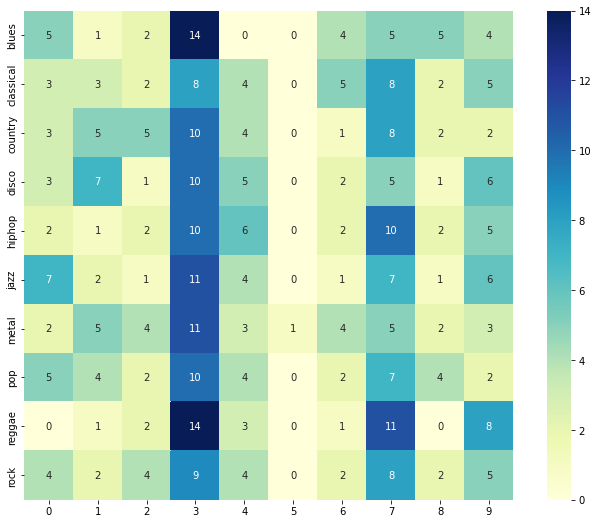

In [115]:
model.plot_adjusted_matrix(X_test_features_raw, y_test_raw)

In [116]:
model.accuracy_score(X_test_features_raw, y_test_raw)

(400,)
(400,)
Adjusted Rand Score: 0.166


# OLD

In [ ]:
import os
general_path = 'dataset/kaggle'

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:]
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
data.head();

In [ ]:
# Split train and test sets

# Setup Labels: Panda Series -> list of labels -> list of label indices -> np array
y = data['label'].values
y = [genres.index(label) for label in y]
y = np.array(y)

X = data.loc[:, data.columns != 'label'] 
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X.values, y, test_size=0.2, random_state=42)

In [ ]:
# Select genres to keep
def get_data_for_genres(trained_genres, X_test_in, X_train_in, y_test_in, y_train_in):
  X_train_selected = []
  X_test_selected = []
  y_train_selected = []
  y_test_selected = []
  for i in trained_genres:
    X_train_selected.append(X_train_in[y_train_in==i])
    X_test_selected.append(X_test_in[y_test_in==i])
    y_train_selected.append(y_train_in[y_train_in==i])
    y_test_selected.append(y_test_in[y_test_in==i])

  X_train_out = np.array([i for sub in X_train_selected for i in sub])
  X_test_out = np.array([i for sub in X_test_selected for i in sub])
  y_train_out = np.array([i for sub in y_train_selected for i in sub])
  y_test_out = np.array([i for sub in y_test_selected for i in sub])

  return X_train_out, X_test_out, y_train_out, y_test_out

In [ ]:
# Normalize X
def normalize(X_train, X_test):
  min_max_scaler = preprocessing.MinMaxScaler()
  X_train = min_max_scaler.fit_transform(X_train)
  X_test = min_max_scaler.transform(X_test)
  return X_train, X_test

In [ ]:
# PCA
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, n_components=10):
  pca = PCA(n_components=n_components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  return X_train, X_test

In [ ]:
# Confusion Matrix helper methods
def genres_indicies_to_values(trained_genres):
  return [genres[i] for i in trained_genres]

def print_adjusted_matrix(matrix, trained_genres):
  # delete empty rows
  empty_rows = []
  for i in range(matrix.shape[0]):
    if (matrix[i].sum() == 0):
      empty_rows.append(i)
  del_count = 0
  for i in range(len(empty_rows)):
    matrix = np.delete(matrix, (empty_rows[i] - del_count), axis=0)
    del_count = del_count + 1

  final_matrix = matrix[:,0:len(matrix)]

  # print
  plt.figure(figsize = (12,9))
  sns.heatmap(final_matrix, cmap="YlGnBu", annot=True, fmt='d', square=True, 
          xticklabels = [i for i in range(len(final_matrix))],
          yticklabels = genres_indicies_to_values(trained_genres));

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix

# K-Means class wrapper

class KMEANS():
  def __init__(self, trained_genres=genres, max_iter=5000, n_init=50,random_state=0):
    self.trained_genres = genres
    self.kmeans = KMeans(
        n_clusters=len(trained_genres), 
        max_iter=max_iter, 
        n_init=n_init, 
        random_state=random_state)
    
  def fit(self, X):
      self.kmeans.fit(X)

  def predict(self, X):
      return self.kmeans.predict(X)

  def adjusted_rand_score(self, y_true, y_pred):
      return adjusted_rand_score(y_true, y_pred)

  def confusion_matrix(self, y_true, y_pred):
      return confusion_matrix(y_true, y_pred)

Adjusted Rand Score: 0.162


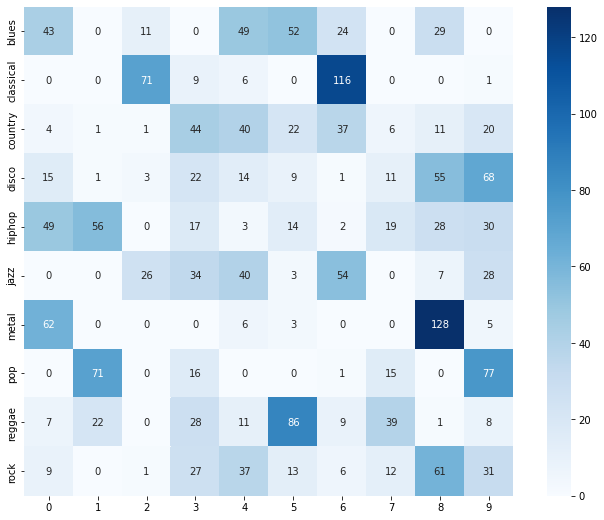

In [ ]:
# genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Prepare data
trained_genres = [0,1,2,3,4,5,6,7,8,9]
# trained_genres = [0,1,3,6,7,8]
#trained_genres = [1,6,8] # no blues, no country, no hip hop, no jazz, no rock, no pop
X_train, X_test, y_train, y_test = get_data_for_genres(
    trained_genres, 
    X_test_raw,
    X_train_raw,
    y_test_raw,
    y_train_raw)
X_train, X_test = normalize(X_train, X_test)
X_train, X_test = apply_pca(X_train, X_test, 10)

# Train
model = KMEANS(trained_genres)
model.fit(X_train)
y_pred = model.predict(X_test)

# Adjusted Rand Score
print("Adjusted Rand Score: %.3f" % model.adjusted_rand_score(y_test, y_pred))

# Confusion Matrix
matrix = model.confusion_matrix(y_test, y_pred)
print_adjusted_matrix(matrix, trained_genres)


# FBANK DATA

In [ ]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.preprocess.feature import Feature
from genrecog.tools.trainer import SklearnTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Load dataset

train_preprocessor = Preprocessor('dataset/npz_files/train.npz')
test_preprocessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create sets

X_raw, y_raw = train_preprocessor.as_shuffled_numpy()
X_test_raw, y_test_raw = test_preprocessor.as_shuffled_numpy()

In [ ]:
# Extract features

feature_maker = Feature()
X_features_raw = feature_maker.numpy_fbank_features(X_raw).reshape(-1,702*40)
X_test_features_raw = feature_maker.numpy_fbank_features(X_test_raw).reshape(-1,702*40)

In [ ]:
# Select genres to consider
# genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
# trained_genres = [1,6,8]
trained_genres = [0,1,2,3,4,5,6,7,8,9]

X_train, X_test, y_train, y_test = get_data_for_genres(
    trained_genres, 
    X_test_features_raw,
    X_features_raw,
    y_test_raw,
    y_raw)

In [ ]:
# Normalize and PCA
X_features, X_test_features = normalize(X_train, X_test)
X_features, X_test_features = apply_pca(X_features, X_test_features, 200)

In [ ]:
# Train
model = KMEANS(trained_genres)
model.fit(X_features)
y_pred_features = model.predict(X_test_features)


Adjusted Rand Score: 0.160


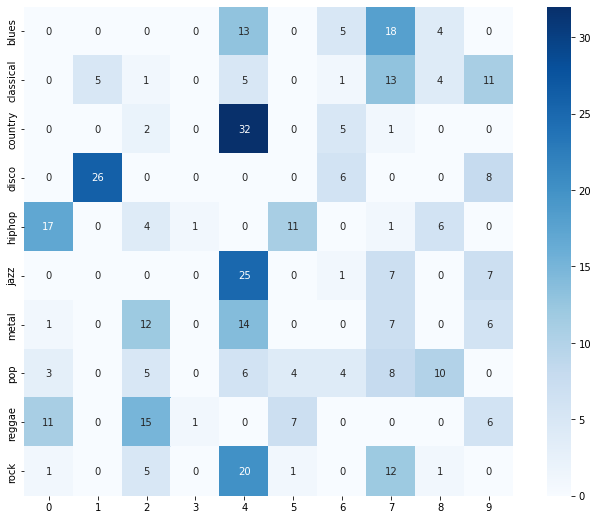

In [ ]:
# Evaluate

# Adjusted Rand Score
print("Adjusted Rand Score: %.3f" % model.adjusted_rand_score(y_test, y_pred_features))

# Confusion Matrix
matrix = model.confusion_matrix(y_test, y_pred_features)
print_adjusted_matrix(matrix, trained_genres)